In [268]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Problem 1
model as 1D problem, with equation:
$$\frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2}$$

Where $C$ is the diffusion ccoefficient. We assume that at t0, the dye injeted at x0 is a delta function in concentration.

The section we are looking at is 10 units long ($0\leq x \leq 10$) and $x0=5$ and $D=0.1$. Boundary conditions are $C(0,t)=C(10,t)=0$.

Number of cells is $N$ so number of points is $N+1$. Our initial condition is $t=2$ from the exact solution. We time step from $t=2$ to $t=4$ on a grid with $N=100$ points with RK4 time stepping, crank nicolson. For RK4 we report the stable time step, and for crank-nicolson, we show the scheme is stable for large CFL. Note that we will need to use a tridiagonal solver to solve the system of equations. The Thomas Algorithm (a tridiagonal solver) is available online, and copy pasted below.

In [269]:
try:
   import numpypy as np    # for compatibility with numpy in pypy
except:
   import numpy as np      # if using numpy in cpython

def TDMASolve(a, b, c, d):
    n = len(a)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    xc = []
    for j in range(1, n):
        if(bc[j - 1] == 0):
            ier = 1
            return
        ac[j] = ac[j]/bc[j-1]
        bc[j] = bc[j] - ac[j]*cc[j-1]
    if(b[n-1] == 0):
        ier = 1
        return
    for j in range(1, n):
        dc[j] = dc[j] - ac[j]*dc[j-1]
    dc[n-1] = dc[n-1]/bc[n-1]
    for j in range(n-2, -1, -1):
        dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
    return dc

In [478]:
L = 10
D = 0.1
x0 = 5

N = 200
numpoints = N+1
dx = L/N
print(dx)



def initial(x,t):
    C = 1/math.sqrt(4*math.pi*D*t)*np.exp(-(x-x0)**2/(4*D*t))
    return C



0.05
8.0


In [392]:
test = np.arange(1,N)
print(test)
print(test.shape)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199]
(199,)


In [488]:


# This gives the slope dC/dt=D*d^2C/dx^2 at each point in x for the solution vector C(x)
def Cent2(fold):
    # print(fold.shape)
    RHSvec = np.zeros(N-1)
    for xindex in np.arange(1,N-1):
        xindex = int(xindex)
        RHSvec[xindex] = D*(fold[xindex+1]-2*fold[xindex]+fold[xindex-1])/dx**2
    RHSvec = np.insert(RHSvec, 0, 0)
    RHSvec = np.insert(RHSvec, N-1, 0)
    # print(RHSvec.shape)
    print(RHSvec)
    return RHSvec

#Next, we want to use the slope evaluations to compute the values at the next time step
def RK4(fold,Spatial=Cent2):
    K0 = Spatial(fold) #Each K variable is a vector of K values
    K1 = Spatial(fold+dt/2*K0)
    K2 = Spatial(fold+dt*K1/2)
    K3 = Spatial(fold+dt*K2)
    fn = fold + (K0+2*K1+2*K2+K3)*dt/6
    return fn

    
#Creates the matrix A that multiplies the vector C^(k+1)
def getA(CFL,N):
    A = np.empty((N-1,N-1))
    for i in range(N-1):
        for j in range(N-1):
            if i == j:
                A[i,j] = 1 + CFL
            elif i == j + 1  or i == j - 1:
                A[i,j] = -CFL/2
    return A

#Creates the matrix B that multiplies the vector C^k
def getB(CFL,N):
    B = np.empty((N-1,N-1))
    for i in range(N-1):
        for j in range(N-1):
            if i == j:
                B[i,j] = 1 - CFL
            elif i == j + 1  or i == j - 1:
                B[i,j] = CFL/2
    return B

def crkncl(Cvec,A,B):
    Ainv = np.linalg.inv(A)
    Cveck1 = Ainv*B*Cvec
    return Cveck1

In [425]:
A = getA(CFL,N)
print(A)

[[ 9. -4.  0. ...  0.  0.  0.]
 [-4.  9. -4. ...  0.  0.  0.]
 [ 0. -4.  9. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  9. -4.  0.]
 [ 0.  0.  0. ... -4.  9. -4.]
 [ 0.  0.  0. ...  0. -4.  9.]]


In [ ]:
def solve(dt=0.1,method=RK4,printvals=False):
    tfinal = 4
    simlength = tfinal-2
    numtsteps = int(simlength/dt)
    x = np.linspace(dx,L-dx,N-1)
    # print(x)
    Cvec0 = initial(x,2)
    Cvec0 = np.insert(Cvec0, 0, 0)
    Cvec0 = np.insert(Cvec0, N, 0)
    # print(Cvec0)
    soln = np.zeros((N+1,numtsteps+1))
    # print(soln.shape)
    soln[:,0] = Cvec0
    
    CFL = D*dt/dx**2
    print(CFL)
    
    # diagnostics for initial condition, simulation inputs
    if printvals:
        print(dt)
        print(2)
        print(0)
        print(Cvec0)
    
    # perform the calcualation
    for tstep in range(1,numtsteps+1):
        t = tstep*dt + 2
        Cvec = soln[:,tstep-1]
        Cveck1 = method(Cvec)
        # Need to make it so that the method only evaluates fnew for elements 1 thru N-1, instead of 0 thru N
        # because at 0 and N, we require C=0
        soln[:,tstep] = Cveck1
        # diagnostics for each time step
        if printvals:
            print(t)
            print(tstep)
            print(Cveck1)
    # prepare x vector for packaging
    x = np.insert(x,0,0)
    x = np.insert(x,N,10)
    x = np.reshape(x,(-1,1))
    # print(x.shape)
    # print(soln.shape)
    
    # package the result
    packagedsoln = np.append(soln,x,1)
    # print(packagedsoln[:,-1])
    return packagedsoln

In [ ]:
soln = solve(dt=0.1,method=RK4,printvals=False)

[0.00000000e+00 3.14959267e-14 5.82930705e-14 1.07217366e-13
 1.95974241e-13 3.55974190e-13 6.42574798e-13 1.15269531e-12
 2.05490157e-12 3.64043416e-12 6.40915828e-12 1.12133266e-11
 1.94963633e-11 3.36866949e-11 5.78427400e-11 9.87017768e-11
 1.67373518e-10 2.82055243e-10 4.72353643e-10 7.86114887e-10
 1.30014093e-09 2.13688181e-09 3.49024757e-09 5.66523100e-09
 9.13828444e-09 1.46486425e-08 2.33354268e-08 3.69419466e-08
 5.81178398e-08 9.08625268e-08 1.41171106e-07 2.17967871e-07
 3.34445076e-07 5.09967842e-07 7.72763205e-07 1.16368581e-06
 1.74144877e-06 2.58983040e-06 3.82752121e-06 5.62146548e-06
 8.20478393e-06 1.19006425e-05 1.71537600e-05 2.45716267e-05
 3.49779335e-05 4.94811798e-05 6.95619269e-05 9.71826688e-05
 1.34924774e-04 1.86157370e-04 2.55243347e-04 3.47787754e-04
 4.70933733e-04 6.33710605e-04 8.47437755e-04 1.12618646e-03
 1.48729958e-03 1.95196608e-03 2.54584371e-03 3.29971833e-03
 4.25018330e-03 5.44031581e-03 6.92032069e-03 8.74810505e-03
 1.09897400e-02 1.371975

In [ ]:
# Want to define a plotting function that will plot:
# the initial condition at t=2
# the true solution at t=4
# the numerical solution at t=4 for 3-4 dt values

def plotpr1(method,dtvals,filename=''):
    
    #initialize figure
    plt.figure(figsize=(10,5))
    axes_internal = plt.gca()
    axes_internal.set_xlabel('$x$')
    axes_internal.set_ylabel('$C$')
    
    #initialize storage and index
    # solns = np.empty((N+1,dtvals.size+1))
    # i = 0
    for dt in dtvals:
        # which dtval/iteration of the loop we are looking at. 1st is 1, nth loop is n
        # i += 1
        
        #solve the problem
        soln = solve(dt,method,printvals=False)
        
        # unpack the solution matrix
        x = soln[:,-1]
        Cvecfinal = soln[:,-2]
        
        # # save relevant values to solution matrix
        # solns[:,0] = x #this will overwrite for every dtval, could be written outside of loop instead...
        # solns[:,i] = Cvecfinal
        plt.plot(x,Cvecfinal, label='$\Delta t=$'+str(dt))
        
        
    # get initial condition, this is computed both every time we solve, as well as here.. could be improved
    Cvec2 = initial(x,2) #was called Cvec0 inside the solution function
    Cvec4 = initial(x,4)
    
    plt.plot(x,Cvec2, label='Exact solution, t=2')
    plt.plot(x,Cvec4, label='Exact solution, t=4')
    
    plt.legend(loc = 'upper right')
    if len(filename) != 0:
        plt.savefig(filename+'.png')
    plt.show()
    return None
    
def plot_methods(x1, y1, x2, y2, x3, y3, tvec, exacty, label1 = 'dt = 0.1',label2 = 'dt = 0.5', label3 =  'dt = 1.0', logscale = False, xlabel='time t (s)', ylabel='Solution Variable y', title='',filename=''):
    plt.figure(figsize=(10,5))
    axes_internal = plt.gca()
    if logscale: 
        # axes_internal.set_yscale('log')
        axes_internal.set_xscale('log')
    axes_internal.set_xlabel(xlabel)
    axes_internal.set_ylabel(ylabel)
    if title: plt.title(title)
    if np.any(y1): plt.plot(x1,y1, label=label1)
    if np.any(y2): plt.plot(x2,y2, label=label2)
    if np.any(y3): plt.plot(x3,y3, label=label3)
    if np.any(exacty): plt.plot(tvec,exacty, label = 'Exact Solution')
    plt.legend(loc = 'upper right')
    if len(filename) != 0:
        plt.savefig(filename+'.png')
    plt.show()
    return None

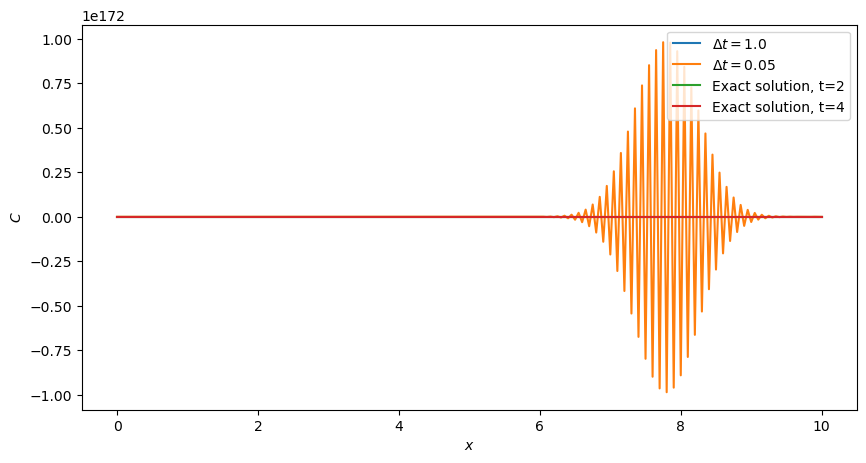

In [ ]:
dtvals = np.array([1,0.05])
plotpr1(RK4,dtvals)

In [ ]:
for tstepm1 in range(0,numtsteps):
    print(tstepm1)

0
1
2
3
4
5
6
7
8
9
